### Sequential Illustration



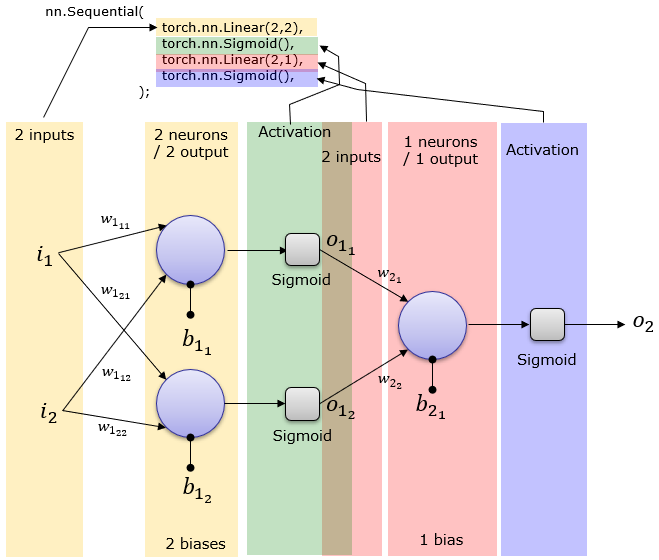

## 1. Make classification data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [ ]:
y[:5]

array([1, 1, 1, 1, 0])

In [ ]:
# make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [ ]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

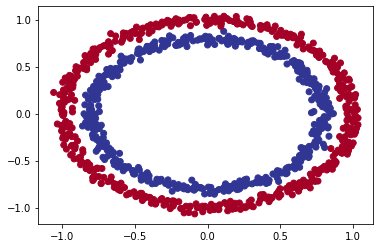

In [ ]:
# visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Toy dataset is a dataset that is small enough to experiment

In [ ]:
# check input and output shape to avoid shape errors in PyTorch

X.shape, y.shape # X has 2 elements, but y has one element

((1000, 2), (1000,))

In [ ]:
import torch
torch.__version__

'1.13.0+cu116'

In [ ]:
X.dtype, type(X)

(dtype('float64'), numpy.ndarray)

In [ ]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [ ]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [ ]:
# split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a Model

let's build a model to classify our blue and red dots.

To do so, we want to:

1. Setup device agnostic code
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and testing loop

In [ ]:
# import PyTorch and nn
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

Now we have setup device agnostic code, let's create a model that;

1. Subclass `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method for our comuptation of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [ ]:
# 1. construct a model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. create 2 nn.Linear layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes 2 features and upscale to 5 features (hidden layer)
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes 5 features from previuos layer and output 1 

  # 3. define a forward() method
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. instantiate an instance of our model and send it to the GPU
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
next(model_0.parameters())

Parameter containing:
tensor([[-0.3571, -0.4347],
        [ 0.2169, -0.0755],
        [-0.1952,  0.5400],
        [ 0.2586, -0.3672],
        [-0.6756, -0.6338]], device='cuda:0', requires_grad=True)

In [ ]:
# let's replicate the model above using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[-0.6086,  0.1437],
                      [-0.0741,  0.1965],
                      [ 0.3088,  0.1034],
                      [-0.0223,  0.5406],
                      [-0.0063, -0.0420]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.1828, -0.3701,  0.3502, -0.3958, -0.5168], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1561, -0.4174,  0.0166, -0.2872, -0.1873]], device='cuda:0')),
             ('1.bias', tensor([-0.1788], device='cuda:0'))])

In [ ]:
# make predicitons
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print(f"predictions length: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Test samples lenght: {len(X_test)}, Shape: {X_test.shape}")

print(f"First 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"First 10 labels:\n{y_test[:10]}")

predictions length: 200, Shape: torch.Size([200, 1])
Test samples lenght: 200, Shape: torch.Size([200, 2])
First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')
First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
# setup the loss function
loss_fn = nn.BCEWithLogitsLoss()

# setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# calculate accuracy - out of 100 examples, what percentage does our model get right?

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() computes element_wise equality
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train a model

Training Loop steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be **raw logits**

We can convert these logits into **prediction prbabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification, softmax for multiclass classification)

Then we can convert our model's prediction to **prediction labels** probabilities by either rounding them or taking the `argmax()`

In [ ]:
# view the first 5 outputs of the forward pass, which is in raw logits format
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0593],
        [-0.0745],
        [ 0.1447],
        [-0.1178],
        [ 0.4053]], device='cuda:0')

In [ ]:
# use the sigmoid activation function on our model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4852],
        [0.4814],
        [0.5361],
        [0.4706],
        [0.6000]], device='cuda:0')

In [ ]:
# find the predicted labels
y_preds = torch.round(y_pred_probs)
y_preds.squeeze()

tensor([0., 0., 1., 0., 1.], device='cuda:0')

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

# put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# build training and evaluation loop
for epoch in range(epochs):
  ## training
  model_0.train()

  # 1. forward pass
  y_logits = model_0(X_train).squeeze() # get rid of dim 1
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. calculate the loss/accuracy
  loss = loss_fn(y_logits,
                 y_train) # because BCE with Logits expects logits format
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backward
  loss.backward()

  # 5. optimizer step (update the params to reduct)
  optimizer.step()
  
  # testing
  model_0.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    
    # print on what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} || Loss: {loss:.5f}, Acc: {acc:.2f}% || Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 || Loss: 0.70189, Acc: 51.38% || Test Loss: 0.69559, Test Acc: 57.00%
Epoch: 10 || Loss: 0.69859, Acc: 51.62% || Test Loss: 0.69354, Test Acc: 50.00%
Epoch: 20 || Loss: 0.69714, Acc: 51.38% || Test Loss: 0.69282, Test Acc: 49.50%
Epoch: 30 || Loss: 0.69637, Acc: 50.38% || Test Loss: 0.69256, Test Acc: 50.50%
Epoch: 40 || Loss: 0.69588, Acc: 49.75% || Test Loss: 0.69245, Test Acc: 49.50%
Epoch: 50 || Loss: 0.69552, Acc: 49.88% || Test Loss: 0.69239, Test Acc: 49.50%
Epoch: 60 || Loss: 0.69523, Acc: 49.75% || Test Loss: 0.69236, Test Acc: 49.00%
Epoch: 70 || Loss: 0.69499, Acc: 50.00% || Test Loss: 0.69235, Test Acc: 49.50%
Epoch: 80 || Loss: 0.69478, Acc: 49.62% || Test Loss: 0.69235, Test Acc: 50.00%
Epoch: 90 || Loss: 0.69460, Acc: 49.62% || Test Loss: 0.69235, Test Acc: 50.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model is not going well

let's visualize, visualize, visualize 

Ref: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py

In [ ]:
import requests
from pathlib import Path

# download helper function
if Path("helper_functions.py").is_file():
  print("file already exists")
else:
  print("downloading the helper_functions.py file")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f: # wb means write binary file
    f.write(request.content)

from helper_functions import plot_decision_boundary, plot_predictions

downloading the helper_functions.py file


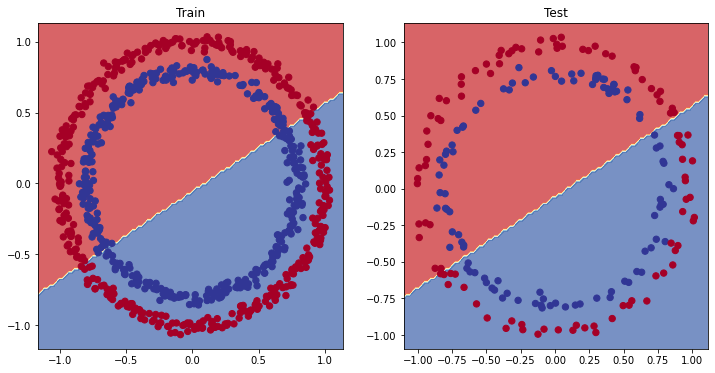

In [ ]:
# plot decision boundayr of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improve a model (from the model perspective)

1. adding more layers
2. increase the number of hidden units (from 5 hidden units to 10 for example)
3. change/add activation function
4. change the optimization function
5. change the learning rate
6. fitting for longer

Activation function applies a non-linear transformation to the output from a layer.

Most Popular activation function:

* ReLU
* Softmax
* Sigmoid

Experiment tracking is all about changing one thing at a time, and check the result, is there degradation or improvement!

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    # return z
    # a way to speed up in PyTorch is to do it once
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
# training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# put data on the target device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels
  
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    
    # print out 
    if epoch % 100 == 0:
      print(f"Epoch: {epoch}, Loss: {loss:3f}, Accuracy: {acc}, Test Loss: {test_loss:3f}, Test Accuracy: {test_acc}")

Epoch: 0, Loss: 0.693955, Accuracy: 50.875, Test Loss: 0.692615, Test Accuracy: 51.0
Epoch: 100, Loss: 0.693048, Accuracy: 50.375, Test Loss: 0.693790, Test Accuracy: 48.0
Epoch: 200, Loss: 0.692986, Accuracy: 51.125, Test Loss: 0.694373, Test Accuracy: 46.0
Epoch: 300, Loss: 0.692980, Accuracy: 51.625, Test Loss: 0.694577, Test Accuracy: 45.0
Epoch: 400, Loss: 0.692980, Accuracy: 51.125, Test Loss: 0.694645, Test Accuracy: 46.0
Epoch: 500, Loss: 0.692980, Accuracy: 51.0, Test Loss: 0.694668, Test Accuracy: 46.0
Epoch: 600, Loss: 0.692980, Accuracy: 51.0, Test Loss: 0.694676, Test Accuracy: 46.0
Epoch: 700, Loss: 0.692980, Accuracy: 51.0, Test Loss: 0.694678, Test Accuracy: 46.0
Epoch: 800, Loss: 0.692980, Accuracy: 51.0, Test Loss: 0.694679, Test Accuracy: 46.0
Epoch: 900, Loss: 0.692980, Accuracy: 51.0, Test Loss: 0.694679, Test Accuracy: 46.0


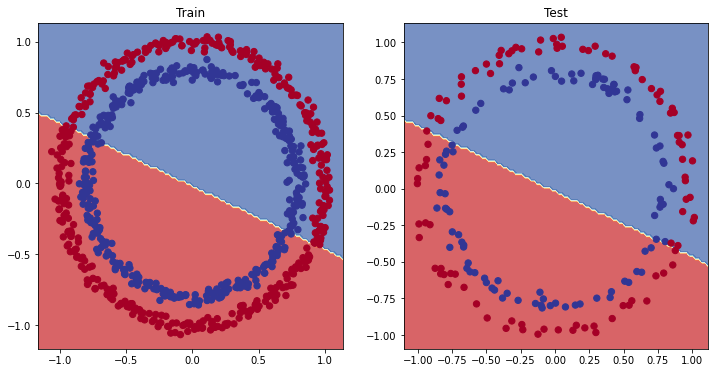

In [ ]:
# plot the decision boundry 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [ ]:
# create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# create train and test split
train_split = int(0.8 * len(X_regression))
X_train_reg, y_train_reg = X_regression[:train_split], y_regression[:train_split]
X_test_reg, y_test_reg = X_regression[train_split:], y_regression[train_split:]

len(X_train_reg), len(X_test_reg), len(y_train_reg), len(y_test_reg)

(80, 20, 80, 20)

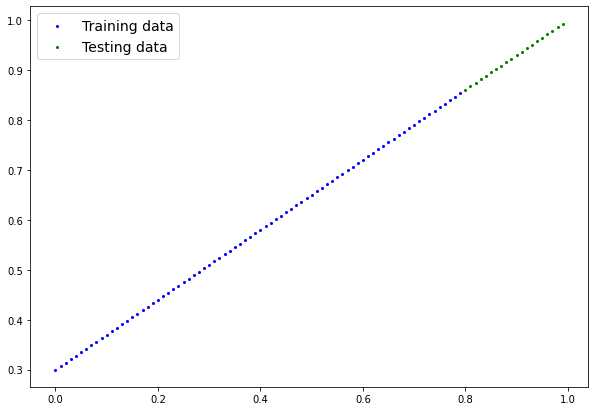

In [ ]:
plot_predictions(train_data=X_train_reg,
                 train_labels=y_train_reg,
                 test_data=X_test_reg,
                 test_labels=y_test_reg)

In [ ]:
X_train_reg.shape

torch.Size([80, 1])

### Adjusting `model_1` to fit a straight line

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [ ]:
# train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for epoch in range(epochs):
  model_2.train()

  y_pred = model_2(X_train_reg)

  loss = loss_fn(y_pred, y_train_reg)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()

  with torch.inference_mode():
    test_pred = model_2(X_test_reg)

    test_loss = loss_fn(test_pred, y_test_reg)

  # print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.5f}, Test Loss: {test_loss:.5f}")

Epoch: 0, Loss: 0.75986, Test Loss: 0.91103
Epoch: 100, Loss: 0.02858, Test Loss: 0.00081
Epoch: 200, Loss: 0.02533, Test Loss: 0.00209
Epoch: 300, Loss: 0.02137, Test Loss: 0.00305
Epoch: 400, Loss: 0.01964, Test Loss: 0.00341
Epoch: 500, Loss: 0.01940, Test Loss: 0.00387
Epoch: 600, Loss: 0.01903, Test Loss: 0.00379
Epoch: 700, Loss: 0.01878, Test Loss: 0.00381
Epoch: 800, Loss: 0.01840, Test Loss: 0.00329
Epoch: 900, Loss: 0.01798, Test Loss: 0.00360


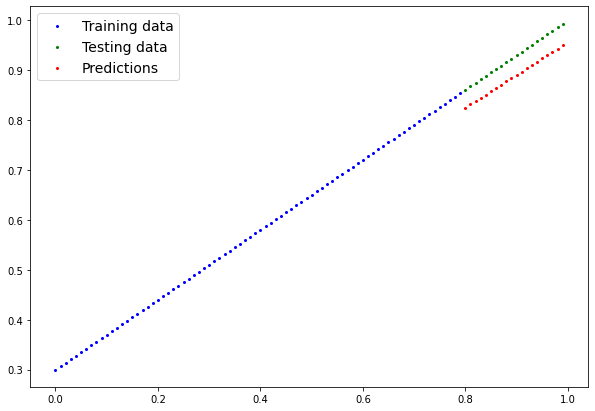

In [ ]:
# make predictions

model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test_reg)

# Visualize
plot_predictions(train_data=X_train_reg.cpu(),
                 train_labels=y_train_reg.cpu(),
                 test_data=X_test_reg.cpu(),
                 test_labels=y_test_reg.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity 

The whole idea here is combining the power of linear and nonlinear functions.

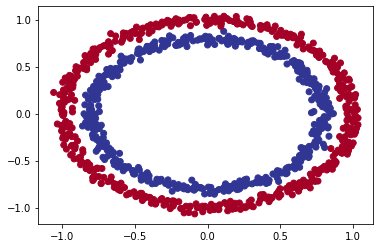

In [ ]:
# make and plot data

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# convert data into tensors, and split the data

import torch
from sklearn.model_selection import train_test_split

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

In [ ]:
# build a model with non-linear activation function

from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    # where should we put our non-linear activation function?!
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# create an optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [ ]:
# training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# build training and evaluation loop

for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred prob -> pred labels
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    
    test_loss = loss_fn(test_logits, 
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
  
  if epoch % 100 == 0:  
    print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {acc:.2f}%, Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.2f}%")

Epoch: 0, Loss: 0.6929, Acc: 50.00%, Test loss: 0.6932, Test accuracy: 50.00%
Epoch: 100, Loss: 0.6912, Acc: 52.88%, Test loss: 0.6910, Test accuracy: 52.50%
Epoch: 200, Loss: 0.6898, Acc: 53.37%, Test loss: 0.6894, Test accuracy: 55.00%
Epoch: 300, Loss: 0.6879, Acc: 53.00%, Test loss: 0.6872, Test accuracy: 56.00%
Epoch: 400, Loss: 0.6852, Acc: 52.75%, Test loss: 0.6841, Test accuracy: 56.50%
Epoch: 500, Loss: 0.6810, Acc: 52.75%, Test loss: 0.6794, Test accuracy: 56.50%
Epoch: 600, Loss: 0.6751, Acc: 54.50%, Test loss: 0.6729, Test accuracy: 56.00%
Epoch: 700, Loss: 0.6666, Acc: 58.38%, Test loss: 0.6632, Test accuracy: 59.00%
Epoch: 800, Loss: 0.6516, Acc: 64.00%, Test loss: 0.6476, Test accuracy: 67.50%
Epoch: 900, Loss: 0.6236, Acc: 74.00%, Test loss: 0.6215, Test accuracy: 79.00%


In [ ]:
# make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

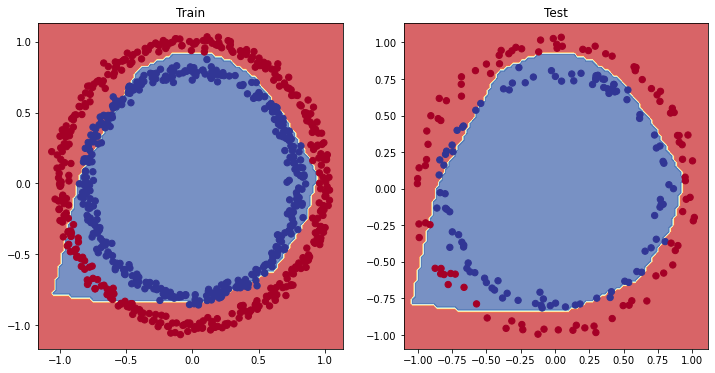

In [ ]:
# visualize, visualize, visualize
# plot the decision boundry 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## Replicating the activation functions

In [ ]:
# create a tensor

A = torch.arange(-10, 10, 1, dtype=torch.float)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

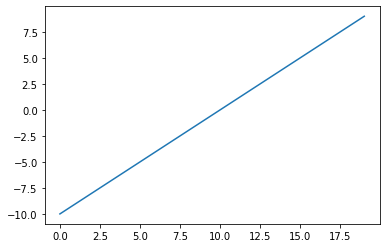

In [ ]:
# visualize the tensor
plt.plot(A)

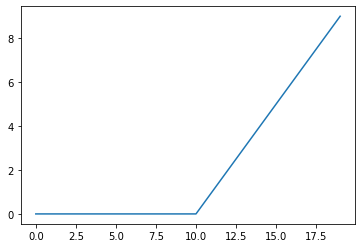

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
def relu(x: torch.Tensor) ->torch.Tensor:
  return torch.max(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

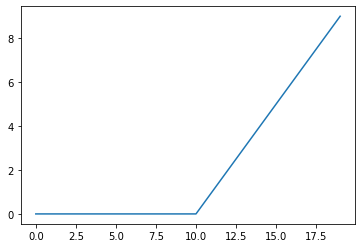

In [ ]:
plt.plot(relu(A))

In [ ]:
# now let's do the same for sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

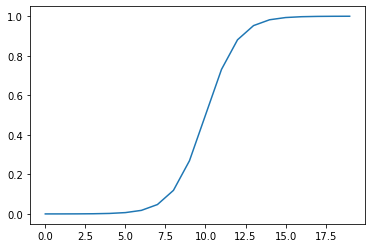

In [ ]:
plt.plot(sigmoid(A))

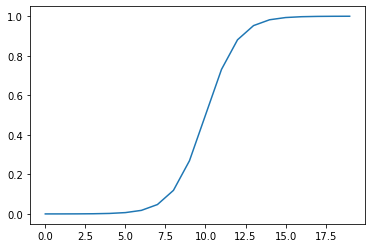

In [ ]:
plt.plot(torch.sigmoid(A))

## Putting it all together with a multiclass classification problem

### 1. Creating a toy multi-class datasets

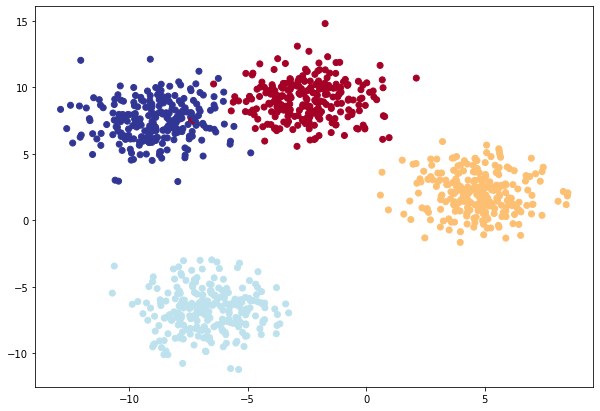

In [ ]:
# import dependencies

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. split the data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### Build a model

In [ ]:
# creating device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# build a multiclass classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initialization a model.

    Args:
      input_features (int)
      out_features (int)
      hidden_units (int)
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  
  def forward(self, x):
    return self.linear_layer_stack(x)

# create an instance, and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [ ]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### Loss function and optimizer for the model

Softmax is an activation function (usually placed as the last layer in the DL model) that scales numbers/logits into probabilities

https://towardsdatascience.com/softmax-activation-function-how-it-actually-works-d292d335bd78

The purpose of the Cross-Entropy is to take the output porbabilities from softmax activation function and measure the distance from the truth values

In [ ]:
# create a loss function for a multi-class classification
# loss function measures how wrong our model's predicitions are
loss_fn = nn.CrossEntropyLoss()

# create an optimizer (e.g. SGD or Adam)
# optimizer updates our model params to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### Getting prediction probabilities for a multi-class PyTorch model

logits (raw output of the model) -> pred prob (use `torch.softmax`) ->pred labels (take the `argmax` of the prediction probabilities)

In [ ]:
next(model_4.parameters()).device

device(type='cuda', index=0)

In [ ]:
X_blob_test.device

device(type='cpu')

In [ ]:
# let's get some raw output of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')

In [ ]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

In [ ]:
# we need to have the same format for X and y
# convert our model's logit output to predicition probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

print(y_pred_probs[:5])
print(y_logits[:5])

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')
tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')


In [ ]:
torch.sum(y_pred_probs[0]) # the sum is equal 1 (because of softmax)

tensor(1., device='cuda:0')

In [ ]:
torch.max(y_pred_probs[0])

tensor(0.3244, device='cuda:0')

In [ ]:
torch.argmax(y_pred_probs[0]) # return the max index

tensor(1, device='cuda:0')

In [ ]:
# convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

### Creating a training and testing loop for a multi-class model

In [ ]:
# fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
epochs = 100

# put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()
  
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()
  
  loss.backward()
  
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits,
                        y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_pred)
    
  if epoch % 10 == 0:
    print(f"Epoch: {epoch}, Loss:{loss:.4f}, Accuracy:{acc:.2f}%, Test Loss:{test_loss:.4f}, Test Accuracy:{test_acc:.2f}%")

Epoch: 0, Loss:1.1588, Accuracy:40.38%, Test Loss:1.0755, Test Accuracy:48.00%
Epoch: 10, Loss:0.6448, Accuracy:96.75%, Test Loss:0.6607, Test Accuracy:97.50%
Epoch: 20, Loss:0.4254, Accuracy:98.50%, Test Loss:0.4307, Test Accuracy:100.00%
Epoch: 30, Loss:0.2529, Accuracy:99.12%, Test Loss:0.2451, Test Accuracy:99.50%
Epoch: 40, Loss:0.1123, Accuracy:99.25%, Test Loss:0.1023, Test Accuracy:99.50%
Epoch: 50, Loss:0.0663, Accuracy:99.25%, Test Loss:0.0585, Test Accuracy:99.50%
Epoch: 60, Loss:0.0507, Accuracy:99.25%, Test Loss:0.0429, Test Accuracy:99.50%
Epoch: 70, Loss:0.0430, Accuracy:99.25%, Test Loss:0.0349, Test Accuracy:99.50%
Epoch: 80, Loss:0.0384, Accuracy:99.25%, Test Loss:0.0299, Test Accuracy:99.50%
Epoch: 90, Loss:0.0352, Accuracy:99.25%, Test Loss:0.0266, Test Accuracy:99.50%


### Making and evauating predictions

In [ ]:
# make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

In [ ]:
# from logits -> pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)

In [ ]:
# from pred probs -> pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5]

tensor([1, 3, 2, 1, 0], device='cuda:0')

In [ ]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0], device='cuda:0')

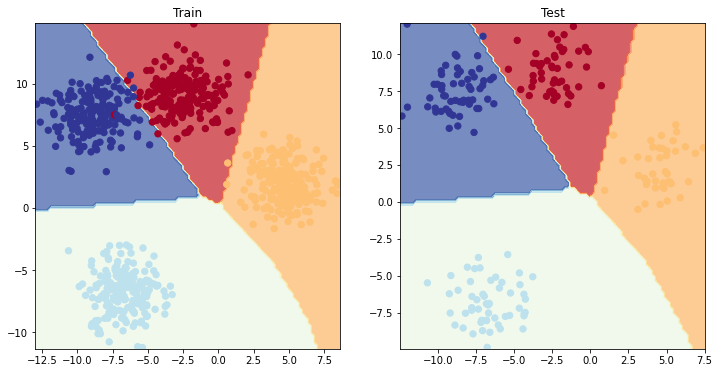

In [ ]:
# visualize, visualize, visualize
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### A few more calssification metrics ... to evaluate our classification model

* accuracy
* precision
* recall
* F1-score
* confusion matrix
* classification report

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 20.9 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

# setup metric
torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')